Sebastian Raschka, 2015

#Python Machine Learning Essentials

# Chapter 3 - A Tour of Machine Learning Classifiers Using Scikit-Learn

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scikit-learn

UsageError: unrecognized arguments: Raschka'

In [2]:
# to install watermark just uncomment the following line:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

### Sections

- [First steps with scikit-learn](#First-steps-with-scikit-learn)
    - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data )
    - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
- [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
- [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
- [Solving non-linear problems using a kernel SVM](#Solving-non-linear-problems-using-a-kernel-SVM)
- [Decision trees learning](#Decision-trees-learning)
- [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
- [K-nearest neighbors - a lazy learning algorithm](#K-nearest-neighbors---a-lazy-learning-algorithm)

<br>
<br>

<br>
<br>

# First steps with scikit-learn

[[back to top](#Sections)]

## Loading and preprocessing the data

[[back to top](#Sections)]

Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower samples. The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


Splitting data into 70% training and 30% test data:

In [7]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

Standardizing the features:

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

<br>
<br>

##Training a perceptron via scikit-learn

[[back to top](#Sections)]

Redefining the `plot_decision_region` function from chapter 2:

In [9]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [10]:
y_test.shape

(45,)

In [11]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 4


In [12]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.91


In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]                               
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
        
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]   
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', 
                alpha=1.0, linewidth=1, marker='o', 
                s=55, label='test set')

Training a perceptron model using the standardized training data:

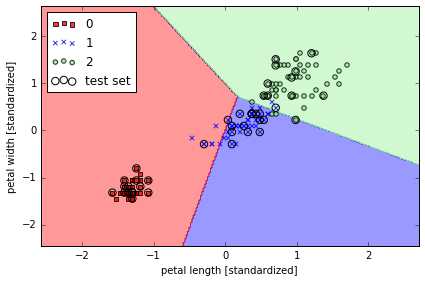

In [14]:
%matplotlib inline

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, 
                      classifier=ppn, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/iris_perceptron_scikit.png', dpi=300)
plt.show()

<br>
<br>

# Modeling class probabilities via logistic regression

[[back to top](#Sections)]

Plot sigmoid function:

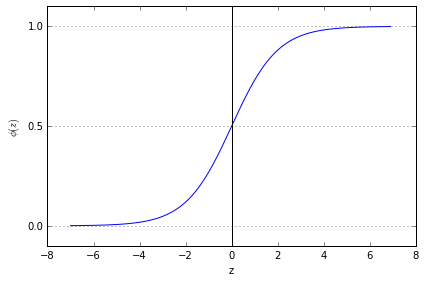

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('./figures/sigmoid.png', dpi=300)
plt.show()

Plot cost function:

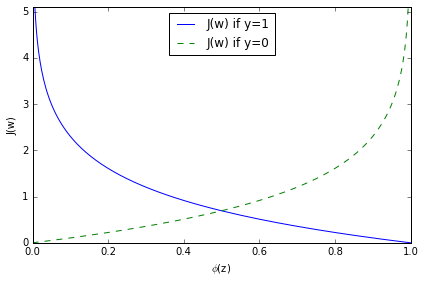

In [20]:
def cost_1(z):
    return - np.log(sigmoid(z))
                   
def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/log_cost.png', dpi=300)
plt.show()

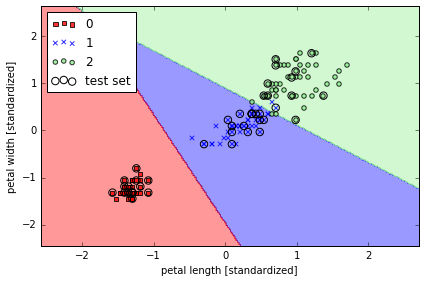

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=lr, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

In [23]:
lr.predict_proba(X_test_std[0,:])

C:\Users\younggy\Anaconda\envs\python3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[  2.05743774e-11,   6.31620264e-02,   9.36837974e-01]])

Regularization path:

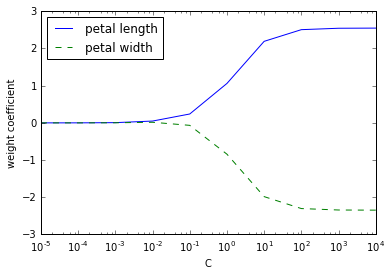

In [25]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], 
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', 
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
# plt.savefig('./figures/regression_path.png', dpi=300)
plt.show()

<br>
<br>

# Maximum margin classification with support vector machines

[[back to top](#Sections)]

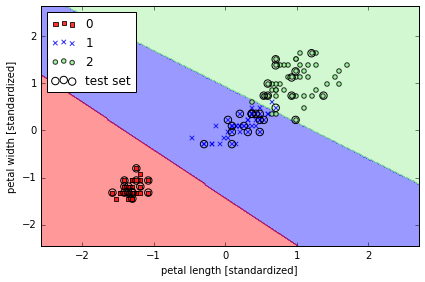

In [26]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_linear.png', dpi=300)
plt.show()

<br>
<br>

# Solving non-linear problems using a kernel SVM

[[back to top](#Sections)]

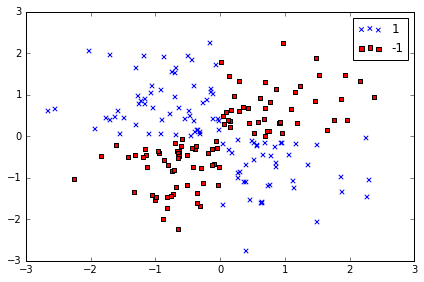

In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()

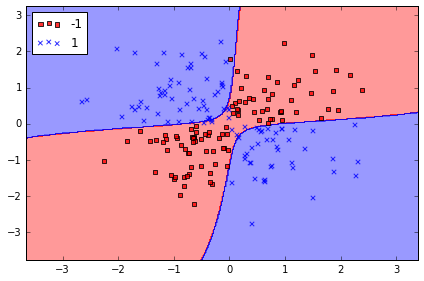

In [34]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, 
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_xor.png', dpi=300)
plt.show()

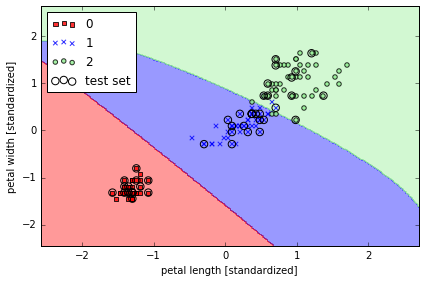

In [35]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_1.png', dpi=300)
plt.show()

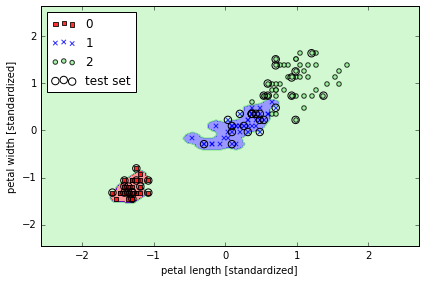

In [36]:
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_2.png', dpi=300)
plt.show()

<br>
<br>

# Decision trees learning

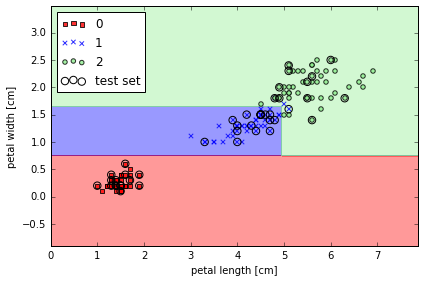

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)
plt.show()

[[back to top](#Sections)]

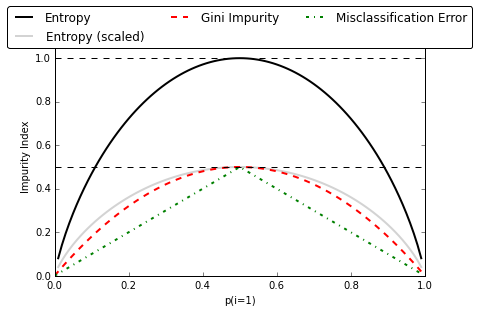

In [23]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def gini(p):
    return (p)*(1 - (p)) + (1-p)*(1 - (1-p))

def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]


fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                  ['Entropy', 'Entropy (scaled)', 
                   'Gini Impurity', 'Misclassification Error'],
                  ['-', '-', '--', '-.'],
                  ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)



ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
from sklearn.tree import export_graphviz

export_graphviz(tree, 
                out_file='tree.dot', 
                feature_names=['petal length', 'petal width'])

<br>
<br>

# Combining weak to strong learners via random forests

[[back to top](#Sections)]

In [43]:
RandomForestClassifier?

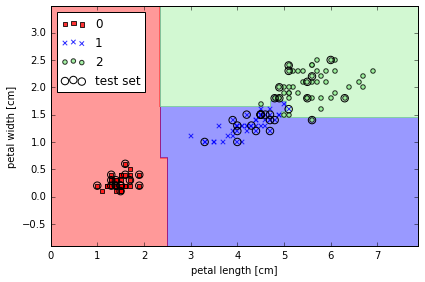

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)
plt.show()

<br>
<br>

# K-nearest neighbors - a lazy learning algorithm

[[back to top](#Sections)]

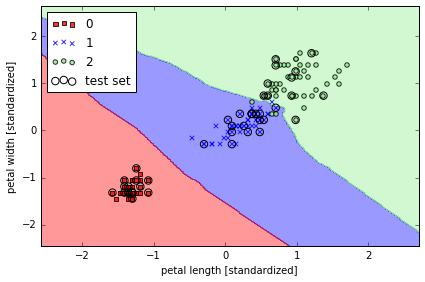

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/k_nearest_neighbors.png', dpi=300)
plt.show()

In [47]:
KNeighborsClassifier?

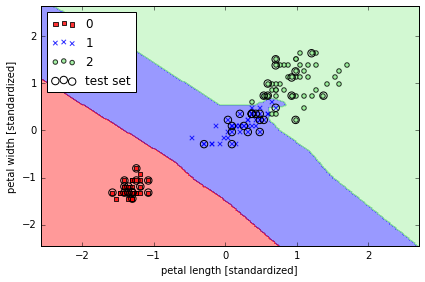

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/k_nearest_neighbors.png', dpi=300)
plt.show()